''' -- coding:utf-8 -- @author: Huaiyu Dong ＆ Yixing Huang @Time: 2023-10-23 @Explanition: This code aims to predict the EAB of microwave absorber structure using the Ensemble of Models-DNN+XGBoost. '''

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

# Set random seed for NumPy
np.random.seed(14618)

# Load your data from mydata_petals.csv
data = pd.read_csv('mydata_petals.csv')

# Extract the last column (EAB) as the target variable
EAB = data.iloc[:, -1].values

# Extract the first 10 columns as input features
input = data.iloc[:, :-1].values

# Create MinMaxScaler objects for input and EAB
scaler_in = MinMaxScaler(feature_range=(-0.5, 0.5))
scaler_out = MinMaxScaler(feature_range=(-0.99, 0.99))

# Fit and transform input data
X = scaler_in.fit_transform(input)
y = scaler_out.fit_transform(EAB.reshape(-1, 1))

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14618)

# Initialize and train the DNN model
input_dim = X_train.shape[1]  # Adjust based on the number of features
output_dim = 1
hidden_dims = [64, 32, 16]  # Adjust the architecture as needed
learning_rate = 0.01
max_epochs = 1000

class DNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super(DNN, self).__init__()
        dims = [input_dim] + hidden_dims + [output_dim]
        self.layers = nn.ModuleList()
        for i in range(1, len(dims)):
            self.layers.append(nn.Linear(dims[i - 1], dims[i]))
            if i < len(dims) - 1:
                self.layers.append(nn.ReLU())  # You can adjust the activation function

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

dnn_model = DNN(input_dim, output_dim, hidden_dims)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(dnn_model.parameters(), lr=learning_rate)

# Training the DNN model
for epoch in range(max_epochs):
    inputs = torch.FloatTensor(X_train)
    targets = torch.FloatTensor(y_train)
    
    optimizer.zero_grad()
    outputs = dnn_model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch + 1}/{max_epochs}], Loss: {loss.item():.4f}")

# Predict with the DNN model
with torch.no_grad():
    dnn_predictions_train = dnn_model(torch.FloatTensor(X_train)).numpy()
    dnn_predictions_test = dnn_model(torch.FloatTensor(X_test)).numpy()

# Initialize and train the XGBoost model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

# Predict with the XGBoost model
xgb_predictions_train = xgb_model.predict(X_train)
xgb_predictions_test = xgb_model.predict(X_test)

# Combine predictions from DNN and XGBoost
combined_predictions_train = np.column_stack((dnn_predictions_train, xgb_predictions_train))
combined_predictions_test = np.column_stack((dnn_predictions_test, xgb_predictions_test))

# Initialize and train the meta-model (XGBoost as an example)
meta_model = xgb.XGBRegressor()
meta_model.fit(combined_predictions_train, y_train)

# Predict with the meta-model
meta_predictions_train = meta_model.predict(combined_predictions_train)
meta_predictions_test = meta_model.predict(combined_predictions_test)

# Transform the predictions back to the original scale
y_train_true = scaler_out.inverse_transform(y_train.reshape(-1, 1)).ravel()
meta_predictions_train = scaler_out.inverse_transform(meta_predictions_train.reshape(-1, 1)).ravel()
y_test_true = scaler_out.inverse_transform(y_test.reshape(-1, 1)).ravel()
meta_predictions_test = scaler_out.inverse_transform(meta_predictions_test.reshape(-1, 1)).ravel()

# Evaluate the meta-model
train_r2 = r2_score(y_train_true, meta_predictions_train)
test_r2 = r2_score(y_test_true, meta_predictions_test)
train_mse = mean_squared_error(y_train_true, meta_predictions_train)
test_mse = mean_squared_error(y_test_true, meta_predictions_test)

print(f"Meta-Model Training R-squared: {train_r2:.4f}")
print(f"Meta-Model Testing R-squared: {test_r2:.4f}")
print(f"Meta-Model Training Mean Squared Error: {train_mse:.4f}")
print(f"Meta-Model Testing Mean Squared Error: {test_mse:.4f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train_true, meta_predictions_train, label='Training Data')
plt.scatter(y_test_true, meta_predictions_test, label='Testing Data')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.title('True vs. Predicted Values for Meta-Model')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(meta_predictions_train, meta_predictions_train - y_train_true, label='Training Data')
plt.scatter(meta_predictions_test, meta_predictions_test - y_test_true, label='Testing Data')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='k', linestyle='--')
plt.legend()
plt.title('Residual Plot for Meta-Model')
plt.grid(True)
plt.show()

ModuleNotFoundError: No module named 'xgboost'

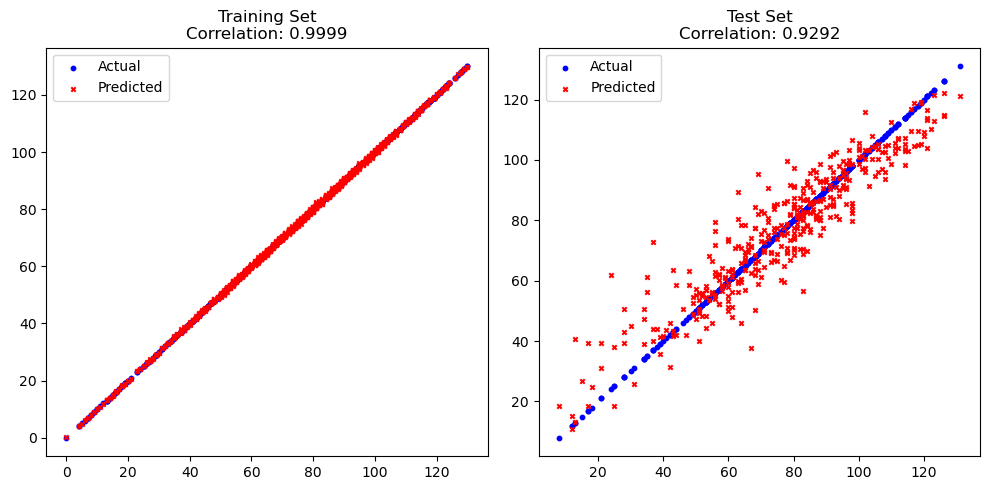

In [5]:
# Additional code to plot correlation
actual_train = y_train_true
predicted_train = meta_predictions_train
actual_test = y_test_true
predicted_test = meta_predictions_test

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Scatter plot of actual values and regression line for training set
axes[0].scatter(actual_train, actual_train, color='blue', label='Actual', marker='o', s=10)
axes[0].scatter(actual_train, predicted_train, color='red', label='Predicted', marker='x', s=10)
#axes[0].set_xlim(-1.2, 1.2)
#axes[0].set_ylim(-1.2, 1.2)
correlation_train = np.corrcoef(actual_train, predicted_train, rowvar=False)[0, 1]
axes[0].set_title(f'Training Set\nCorrelation: {correlation_train:.4f}')
axes[0].legend()


# Scatter plot of actual values and regression line for test set
axes[1].scatter(actual_test, actual_test, color='blue', label='Actual', marker='o', s=10)
axes[1].scatter(actual_test, predicted_test, color='red', label='Predicted', marker='x', s=10)
#axes[1].set_xlim(-1.2, 1.2)
#axes[1].set_ylim(-1.2, 1.2)
correlation_test = np.corrcoef(actual_test, predicted_test, rowvar=False)[0, 1]
axes[1].set_title(f'Test Set\nCorrelation: {correlation_test:.4f}')
axes[1].legend()

plt.tight_layout()
plt.show()